In [2]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from pytorch_pretrained_vit import ViT
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image
import warnings

In [29]:
#hyper params
lr = 1e-3
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 60
hardness_threshold = 0.75
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4
classes = [0,1,17,2,3,4] #arranged in order of their placement in the folder
num_classes = len(classes)
path = './Irrelevant_Balanced'


In [4]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3,sigma=1.5)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [5]:

def get_dataset(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        #transforms.Lambda(lambda x: transform_denoise(x)),
                                        #transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset

In [6]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [7]:
def train_model(trainset,valset, model, criterion, optimizer, scheduler_train , scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset, batch_size=bs, shuffle=True)
    }

    dataset_sizes_strong = {'train': len(trainset), 'val': len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    E_accuracy_train = []
    E_accuracy_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for inputs, labels in dataloaders_strong[phase]:
                inputs = inputs.to(device)                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # AdaMatch steps
                    if phase == 'train':
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())


                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                                                
                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs = inputs[skip_mask]
                            labels = labels[skip_mask]
                            preds = preds[skip_mask]
                            loss = criterion(outputs[skip_mask], preds)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                print()

                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
                print('Number of skipped:', c)
                print()
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                entropy_values_train.append(epoch_entropy.item())
                E_loss_train.append(epoch_loss)
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
                E_accuracy_train.append(epoch_acc)
            else:
                entropy_values_val.append(epoch_entropy.item())
                E_loss_val.append(epoch_loss)
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation
                E_accuracy_val.append(epoch_acc)


            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()

            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch_val = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
        print('Number of skipped:', c)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val,
        E_accuracy_train,
        E_accuracy_val
    )
  

In [32]:
def test_model(model, testset, hardness_threshold):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

         # Calculate hardness score for each sample in the batch
            probabilities_hard = torch.softmax(outputs, dim=1)
            hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

            # Skip predictions if hardness score is greater than the threshold
            skip_mask = hardness_scores <= hardness_threshold
                    
                    
            if skip_mask.sum().item() > 0:
                c += 1
                inputs = inputs[skip_mask]
                labels = labels[skip_mask]
                preds = preds[skip_mask]
                
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / (len(testset)-c)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)
    print("Skipped Inputs:", c)
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [21]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [22]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [23]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        
    elif model_name == "mobilenet":
        # Mobilenet_V2
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = ViT('B_16_imagenet1k', pretrained=True)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [26]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [13]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [14]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Separate the train, val, and test sets
trainset,valset,testset = get_dataset(path, val_size, test_size)

train : 9942 val : 2486 test : 2194


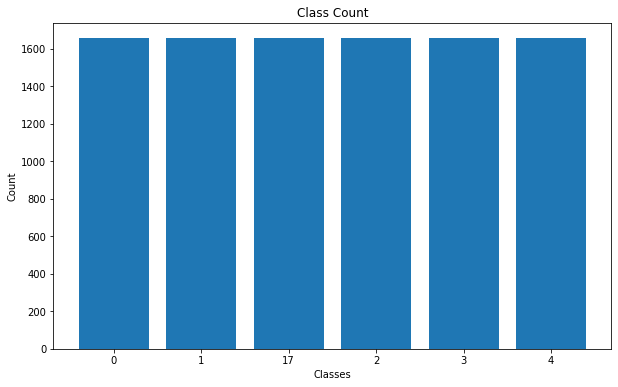

In [15]:
plot_distribution_by_class(trainset_strong, classes)

/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

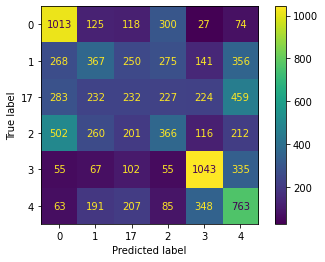

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.5243 Acc: 0.3549
val Epoch Entropy: 1.5850
val Balanced Accuracy: 0.3333



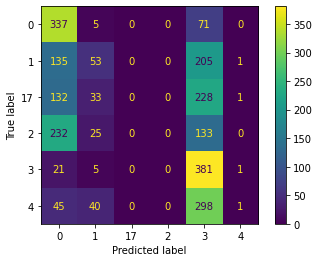

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 1/59
----------

train Loss: 1.3996 Acc: 0.4301
train Epoch Entropy: 1.9870
train Balanced Accuracy: 0.1250



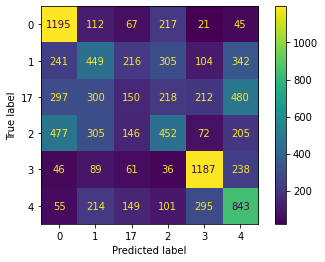

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 1.0089 Acc: 0.5379
val Epoch Entropy: 2.3373
val Balanced Accuracy: 0.3333



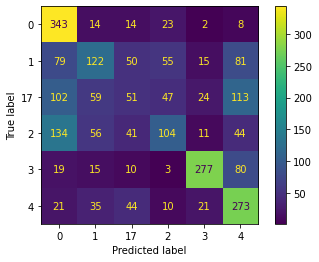

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 2/59
----------

train Loss: 1.3372 Acc: 0.4679
train Epoch Entropy: 1.9098
train Balanced Accuracy: 0.1250



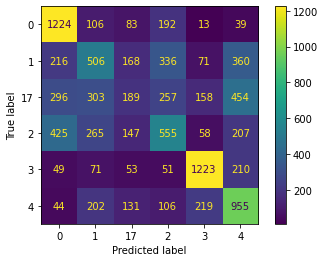

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.9359 Acc: 0.5572
val Epoch Entropy: 2.1450
val Balanced Accuracy: 0.5000



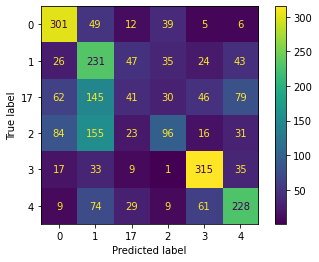

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 3/59
----------

train Loss: 1.3191 Acc: 0.4793
train Epoch Entropy: 1.8807
train Balanced Accuracy: 0.3750



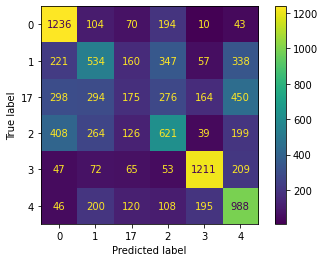

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7744 Acc: 0.5853
val Epoch Entropy: 1.9942
val Balanced Accuracy: 0.0000



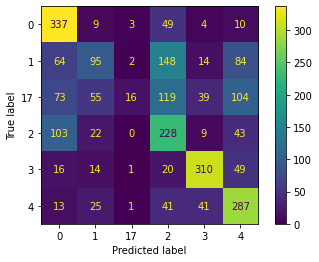

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 4/59
----------

train Loss: 1.2898 Acc: 0.4965
train Epoch Entropy: 1.8448
train Balanced Accuracy: 0.7500



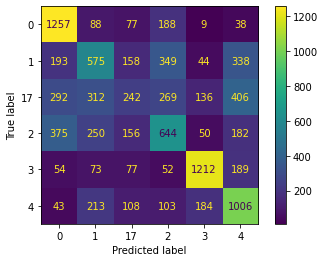

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8603 Acc: 0.5710
val Epoch Entropy: 2.0614
val Balanced Accuracy: 0.4000



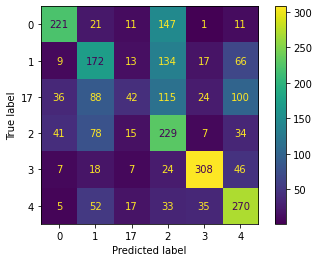

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 5/59
----------

train Loss: 1.2767 Acc: 0.4983
train Epoch Entropy: 1.8268
train Balanced Accuracy: 0.5000



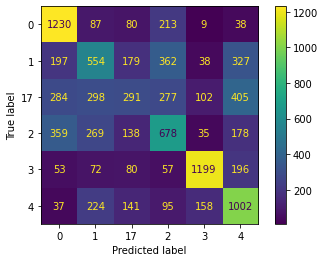

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8309 Acc: 0.5931
val Epoch Entropy: 2.1162
val Balanced Accuracy: 0.6250



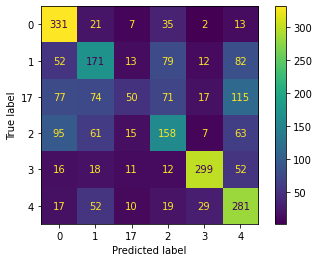

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 6/59
----------

train Loss: 1.2603 Acc: 0.5078
train Epoch Entropy: 1.8068
train Balanced Accuracy: 0.5000



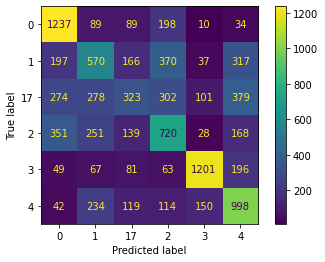

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8475 Acc: 0.6009
val Epoch Entropy: 2.0577
val Balanced Accuracy: 0.3750



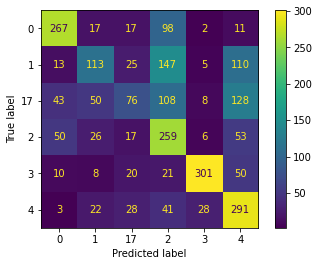

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 7/59
----------

train Loss: 1.2121 Acc: 0.5281
train Epoch Entropy: 1.7887
train Balanced Accuracy: 0.6667



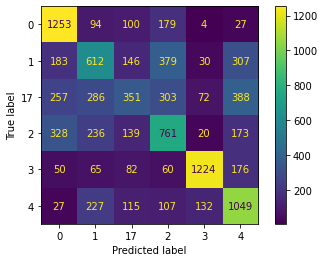

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7708 Acc: 0.6147
val Epoch Entropy: 1.9575
val Balanced Accuracy: 0.9167



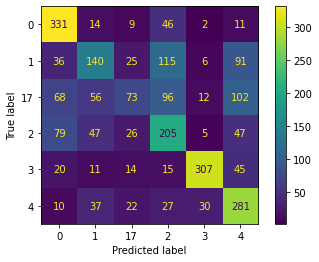

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 8/59
----------

train Loss: 1.1989 Acc: 0.5354
train Epoch Entropy: 1.7488
train Balanced Accuracy: 0.4167



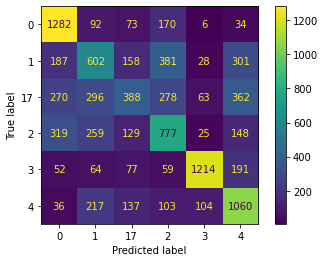

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7510 Acc: 0.6078
val Epoch Entropy: 1.9113
val Balanced Accuracy: 0.3750



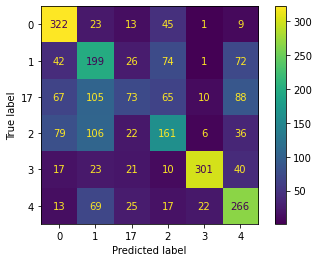

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 9/59
----------

train Loss: 1.1897 Acc: 0.5423
train Epoch Entropy: 1.7205
train Balanced Accuracy: 0.7778



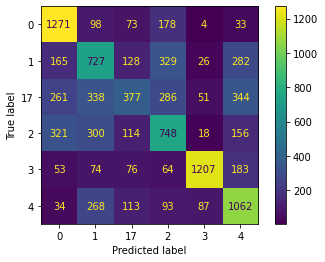

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7567 Acc: 0.6230
val Epoch Entropy: 1.9276
val Balanced Accuracy: 0.6667



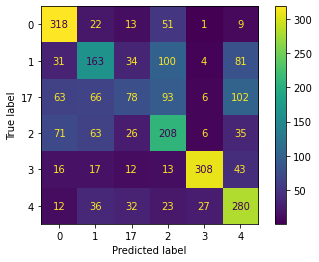

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 10/59
----------

train Loss: 1.1840 Acc: 0.5444
train Epoch Entropy: 1.7279
train Balanced Accuracy: 0.6250



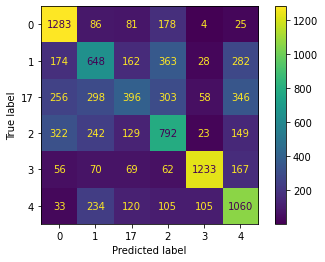

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7630 Acc: 0.6189
val Epoch Entropy: 1.9256
val Balanced Accuracy: 0.7000



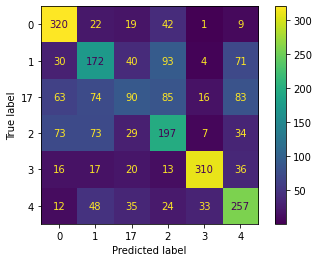

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 11/59
----------

train Loss: 1.1835 Acc: 0.5401
train Epoch Entropy: 1.7270
train Balanced Accuracy: 0.6250



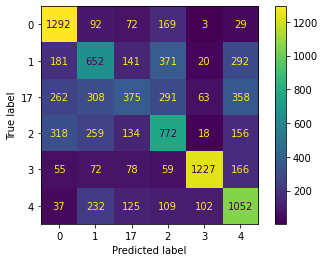

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7568 Acc: 0.6110
val Epoch Entropy: 1.9266
val Balanced Accuracy: 0.5556



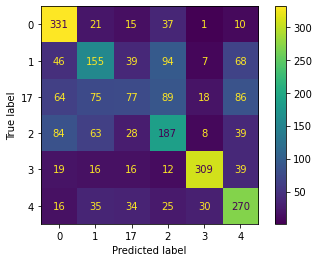

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 12/59
----------

train Loss: 1.1769 Acc: 0.5460
train Epoch Entropy: 1.7235
train Balanced Accuracy: 0.8333



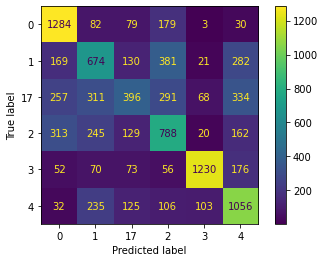

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7552 Acc: 0.6230
val Epoch Entropy: 1.9180
val Balanced Accuracy: 0.2500



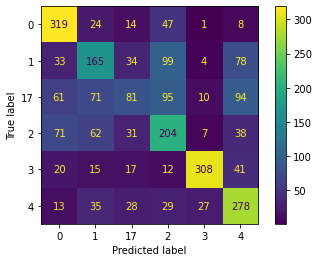

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 13/59
----------

train Loss: 1.1869 Acc: 0.5418
train Epoch Entropy: 1.7195
train Balanced Accuracy: 0.1667



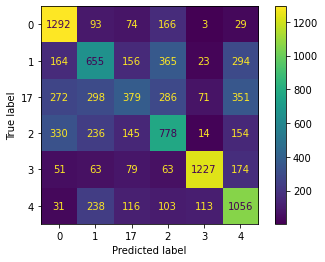

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7505 Acc: 0.6138
val Epoch Entropy: 1.9165
val Balanced Accuracy: 0.6667



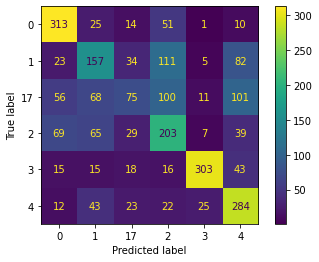

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 14/59
----------

train Loss: 1.1781 Acc: 0.5415
train Epoch Entropy: 1.7219
train Balanced Accuracy: 0.6000



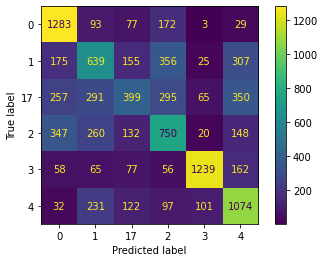

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7590 Acc: 0.6202
val Epoch Entropy: 1.9244
val Balanced Accuracy: 0.6667



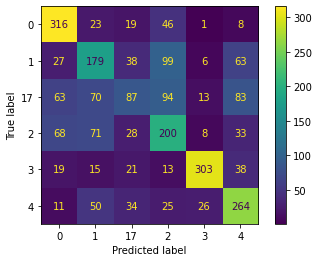

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 15/59
----------

train Loss: 1.1779 Acc: 0.5481
train Epoch Entropy: 1.7237
train Balanced Accuracy: 0.2500



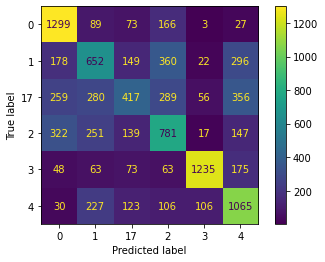

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7546 Acc: 0.6152
val Epoch Entropy: 1.9180
val Balanced Accuracy: 0.2222



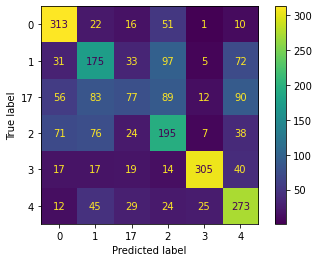

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 16/59
----------

train Loss: 1.1829 Acc: 0.5460
train Epoch Entropy: 1.7235
train Balanced Accuracy: 0.4000



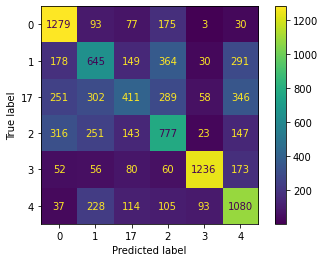

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7622 Acc: 0.6120
val Epoch Entropy: 1.9258
val Balanced Accuracy: 0.5000



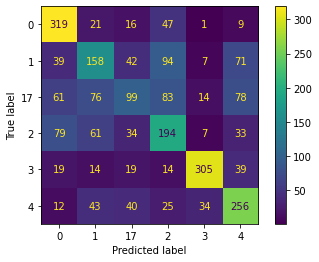

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 17/59
----------

train Loss: 1.1839 Acc: 0.5373
train Epoch Entropy: 1.7209
train Balanced Accuracy: 0.6250



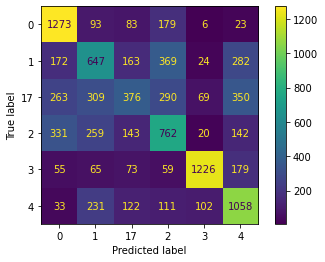

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7555 Acc: 0.6147
val Epoch Entropy: 1.9139
val Balanced Accuracy: 0.2000



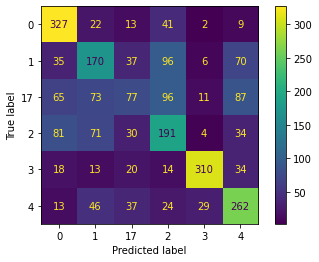

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 18/59
----------

train Loss: 1.1788 Acc: 0.5452
train Epoch Entropy: 1.7205
train Balanced Accuracy: 0.8000



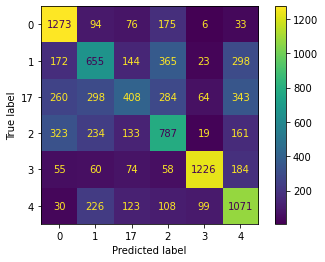

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7498 Acc: 0.6147
val Epoch Entropy: 1.9183
val Balanced Accuracy: 0.8750



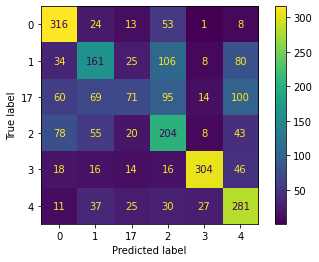

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 19/59
----------

train Loss: 1.1781 Acc: 0.5434
train Epoch Entropy: 1.7207
train Balanced Accuracy: 0.1667



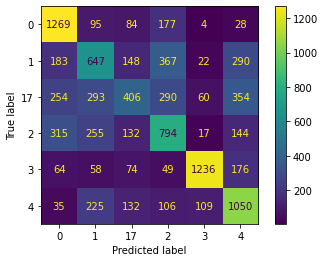

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7504 Acc: 0.6193
val Epoch Entropy: 1.9138
val Balanced Accuracy: 0.3333



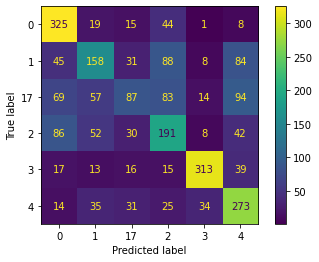

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 20/59
----------

train Loss: 1.1811 Acc: 0.5421
train Epoch Entropy: 1.7212
train Balanced Accuracy: 0.8750



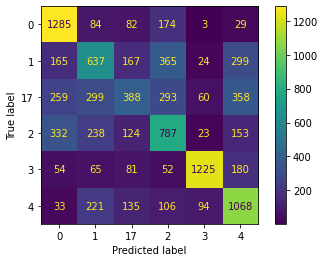

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7539 Acc: 0.6101
val Epoch Entropy: 1.9160
val Balanced Accuracy: 0.6000



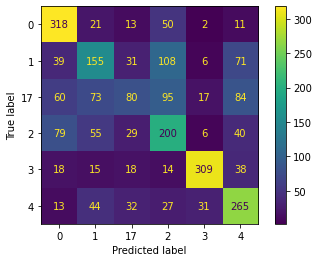

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 21/59
----------

train Loss: 1.1805 Acc: 0.5434
train Epoch Entropy: 1.7237
train Balanced Accuracy: 0.6667



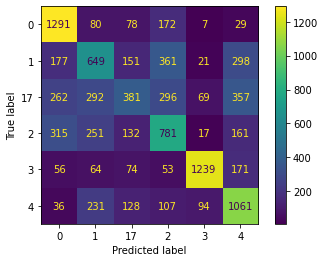

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7560 Acc: 0.6225
val Epoch Entropy: 1.9191
val Balanced Accuracy: 0.7500



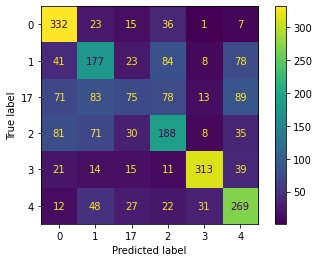

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 22/59
----------

train Loss: 1.1767 Acc: 0.5446
train Epoch Entropy: 1.7226
train Balanced Accuracy: 0.2778



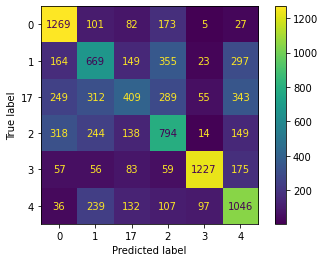

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7595 Acc: 0.6156
val Epoch Entropy: 1.9254
val Balanced Accuracy: 0.6667



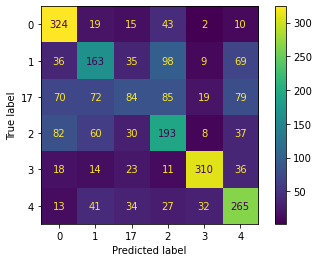

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 23/59
----------

train Loss: 1.1760 Acc: 0.5466
train Epoch Entropy: 1.7230
train Balanced Accuracy: 0.6667



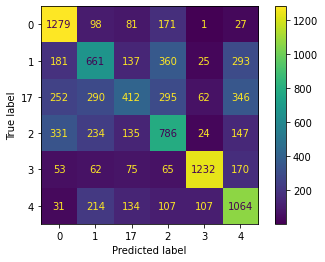

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7448 Acc: 0.6115
val Epoch Entropy: 1.9126
val Balanced Accuracy: 0.5000



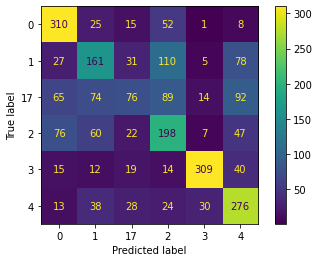

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 24/59
----------

train Loss: 1.1788 Acc: 0.5441
train Epoch Entropy: 1.7195
train Balanced Accuracy: 0.2500



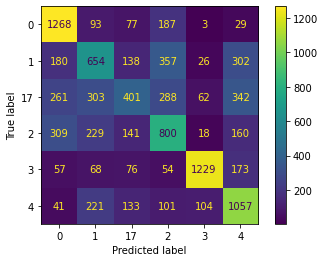

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7602 Acc: 0.6225
val Epoch Entropy: 1.9275
val Balanced Accuracy: 0.6111



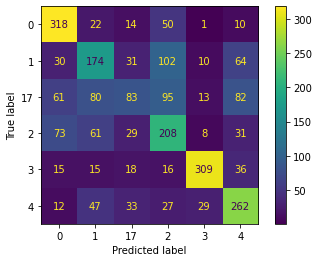

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 25/59
----------

train Loss: 1.1746 Acc: 0.5488
train Epoch Entropy: 1.7223
train Balanced Accuracy: 0.5000



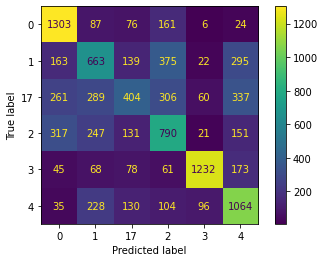

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7541 Acc: 0.6216
val Epoch Entropy: 1.9239
val Balanced Accuracy: 0.7500



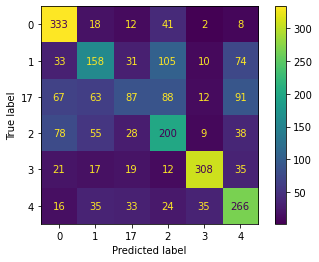

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 26/59
----------

train Loss: 1.1778 Acc: 0.5437
train Epoch Entropy: 1.7247
train Balanced Accuracy: 0.8000



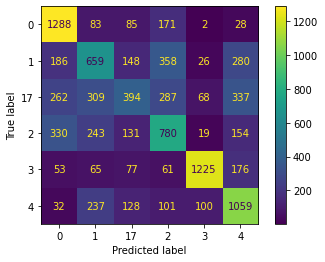

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7506 Acc: 0.6202
val Epoch Entropy: 1.9140
val Balanced Accuracy: 0.3750



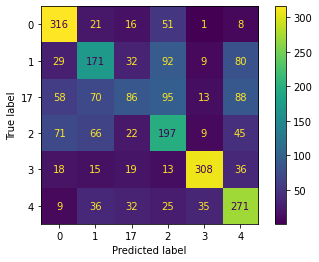

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 27/59
----------

train Loss: 1.1786 Acc: 0.5442
train Epoch Entropy: 1.7198
train Balanced Accuracy: 0.6250



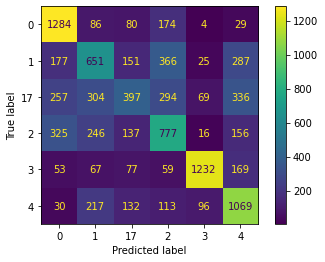

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7470 Acc: 0.6202
val Epoch Entropy: 1.9115
val Balanced Accuracy: 0.5000



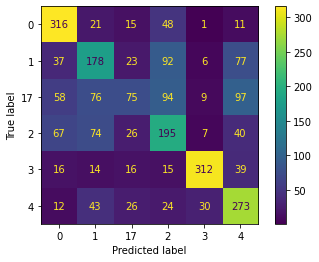

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 28/59
----------

train Loss: 1.1787 Acc: 0.5445
train Epoch Entropy: 1.7204
train Balanced Accuracy: 1.0000



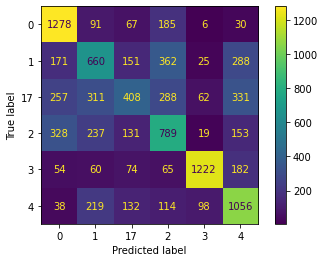

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7600 Acc: 0.6221
val Epoch Entropy: 1.9215
val Balanced Accuracy: 0.5000



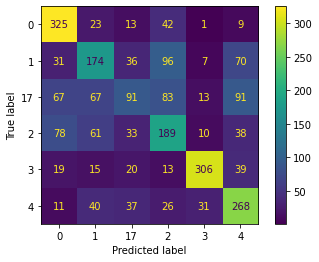

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 29/59
----------

train Loss: 1.1804 Acc: 0.5456
train Epoch Entropy: 1.7251
train Balanced Accuracy: 0.4167



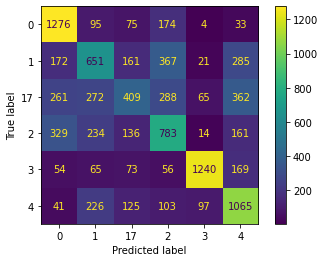

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7560 Acc: 0.6207
val Epoch Entropy: 1.9201
val Balanced Accuracy: 0.7000



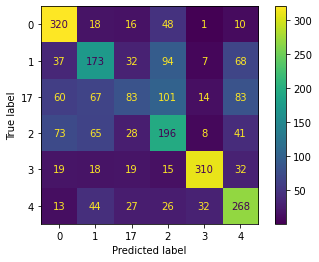

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 30/59
----------

train Loss: 1.1762 Acc: 0.5462
train Epoch Entropy: 1.7226
train Balanced Accuracy: 0.0000



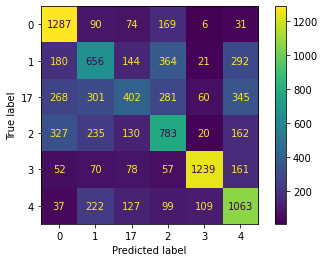

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7663 Acc: 0.6189
val Epoch Entropy: 1.9339
val Balanced Accuracy: 1.0000



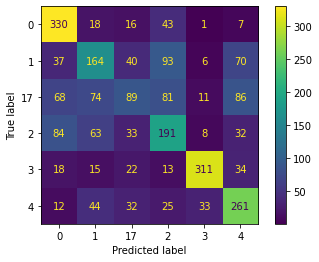

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 31/59
----------

train Loss: 1.1785 Acc: 0.5472
train Epoch Entropy: 1.7191
train Balanced Accuracy: 0.6250



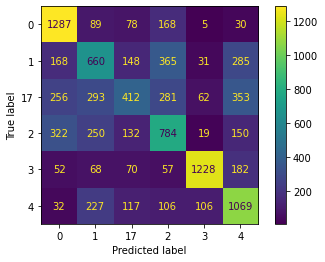

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7531 Acc: 0.6244
val Epoch Entropy: 1.9232
val Balanced Accuracy: 0.5000



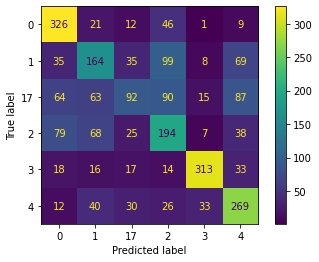

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 32/59
----------

train Loss: 1.1740 Acc: 0.5492
train Epoch Entropy: 1.7213
train Balanced Accuracy: 0.4000



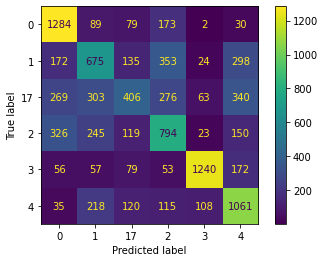

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7597 Acc: 0.6225
val Epoch Entropy: 1.9230
val Balanced Accuracy: 0.6667



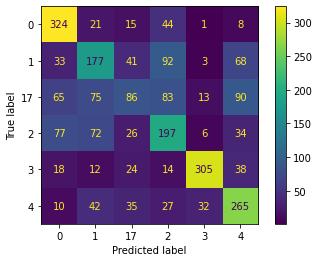

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 33/59
----------

train Loss: 1.1847 Acc: 0.5413
train Epoch Entropy: 1.7240
train Balanced Accuracy: 0.8750



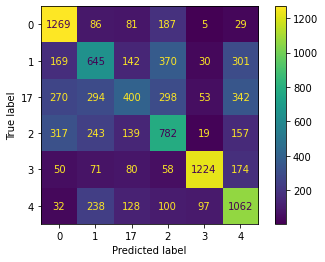

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7715 Acc: 0.6110
val Epoch Entropy: 1.9326
val Balanced Accuracy: 0.5000



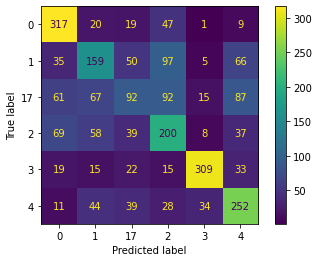

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 34/59
----------

train Loss: 1.1800 Acc: 0.5437
train Epoch Entropy: 1.7158
train Balanced Accuracy: 0.6250



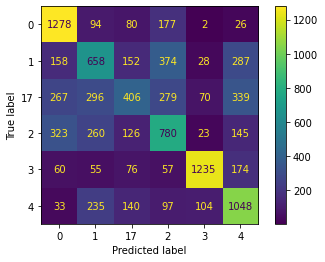

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7519 Acc: 0.6083
val Epoch Entropy: 1.9224
val Balanced Accuracy: 0.2222



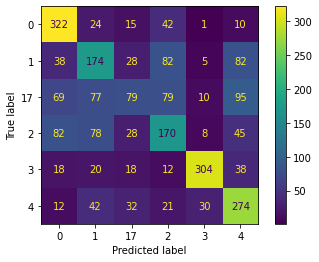

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 35/59
----------

train Loss: 1.1825 Acc: 0.5417
train Epoch Entropy: 1.7220
train Balanced Accuracy: 0.7500



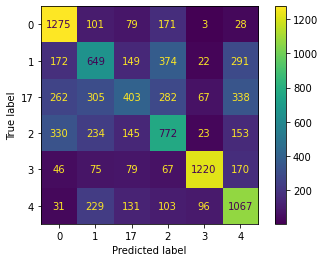

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7689 Acc: 0.6161
val Epoch Entropy: 1.9299
val Balanced Accuracy: 0.6667



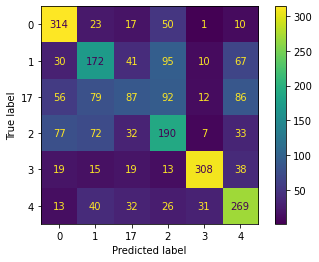

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 36/59
----------

train Loss: 1.1783 Acc: 0.5427
train Epoch Entropy: 1.7188
train Balanced Accuracy: 0.5000



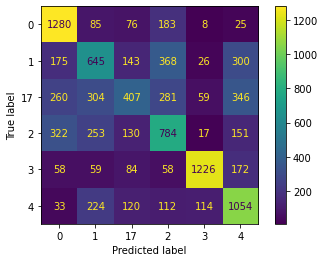

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7568 Acc: 0.6124
val Epoch Entropy: 1.9133
val Balanced Accuracy: 0.3750



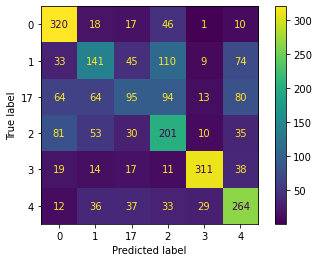

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 37/59
----------

train Loss: 1.1785 Acc: 0.5443
train Epoch Entropy: 1.7200
train Balanced Accuracy: 0.5000



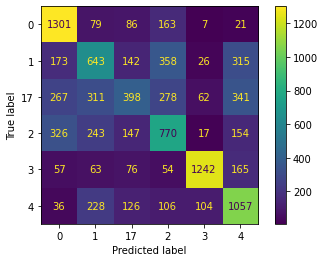

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7641 Acc: 0.6221
val Epoch Entropy: 1.9197
val Balanced Accuracy: 0.3333



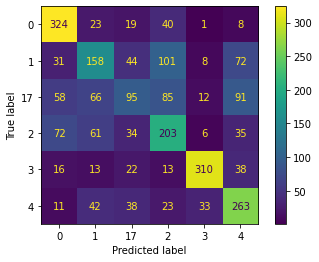

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 38/59
----------

train Loss: 1.1778 Acc: 0.5480
train Epoch Entropy: 1.7202
train Balanced Accuracy: 0.3000



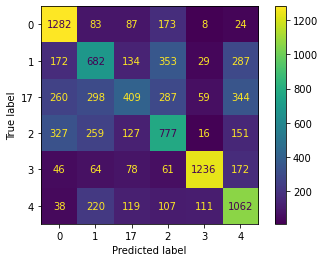

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7472 Acc: 0.6124
val Epoch Entropy: 1.9172
val Balanced Accuracy: 0.6250



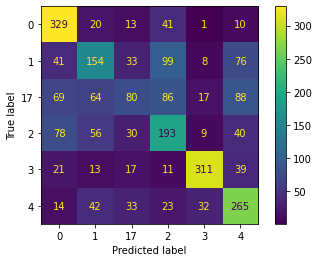

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 39/59
----------

train Loss: 1.1794 Acc: 0.5418
train Epoch Entropy: 1.7222
train Balanced Accuracy: 0.7500



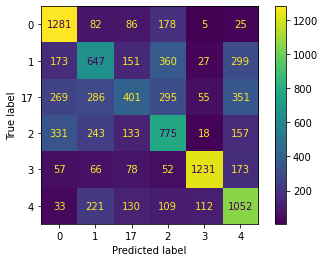

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7497 Acc: 0.6170
val Epoch Entropy: 1.9215
val Balanced Accuracy: 0.3333



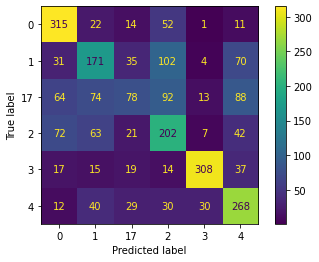

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 40/59
----------

train Loss: 1.1729 Acc: 0.5476
train Epoch Entropy: 1.7206
train Balanced Accuracy: 0.3750



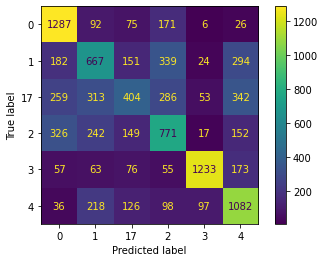

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7543 Acc: 0.6179
val Epoch Entropy: 1.9229
val Balanced Accuracy: 0.5000



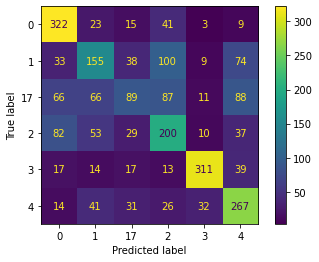

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 41/59
----------

train Loss: 1.1791 Acc: 0.5417
train Epoch Entropy: 1.7216
train Balanced Accuracy: 0.2778



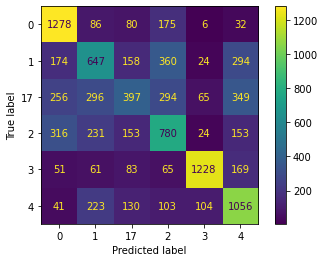

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7564 Acc: 0.6257
val Epoch Entropy: 1.9236
val Balanced Accuracy: 0.2500



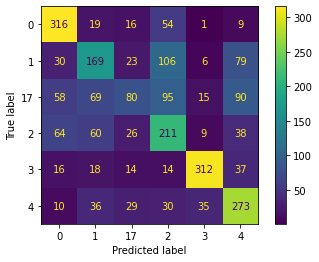

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 42/59
----------

train Loss: 1.1801 Acc: 0.5404
train Epoch Entropy: 1.7196
train Balanced Accuracy: 0.3750



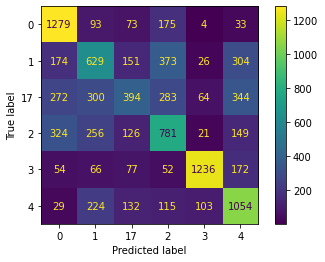

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7590 Acc: 0.6138
val Epoch Entropy: 1.9250
val Balanced Accuracy: 0.5000



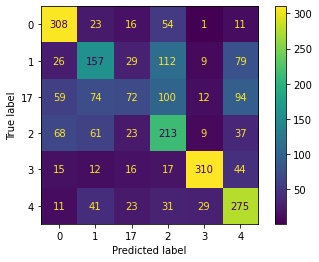

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 43/59
----------

train Loss: 1.1770 Acc: 0.5423
train Epoch Entropy: 1.7220
train Balanced Accuracy: 0.5833



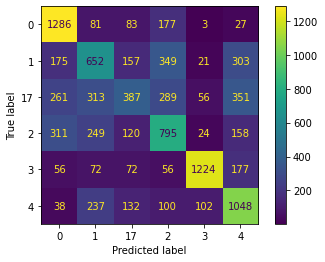

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7535 Acc: 0.6234
val Epoch Entropy: 1.9167
val Balanced Accuracy: 0.7500



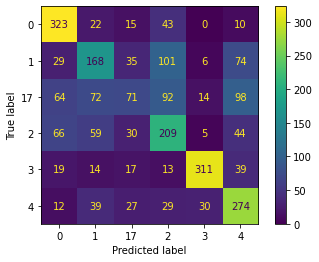

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 44/59
----------

train Loss: 1.1774 Acc: 0.5484
train Epoch Entropy: 1.7211
train Balanced Accuracy: 0.8333



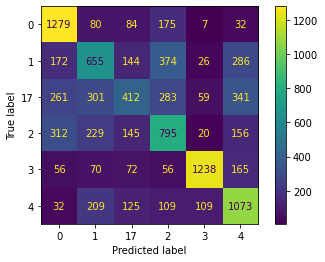

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7592 Acc: 0.6225
val Epoch Entropy: 1.9263
val Balanced Accuracy: 0.8750



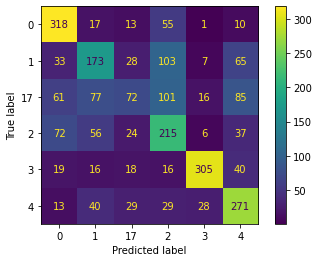

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 45/59
----------

train Loss: 1.1794 Acc: 0.5400
train Epoch Entropy: 1.7208
train Balanced Accuracy: 0.0000



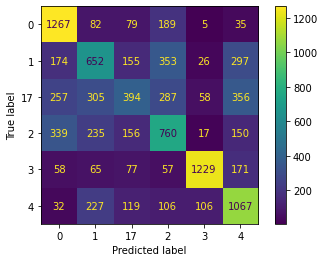

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7495 Acc: 0.6175
val Epoch Entropy: 1.9195
val Balanced Accuracy: 0.7000



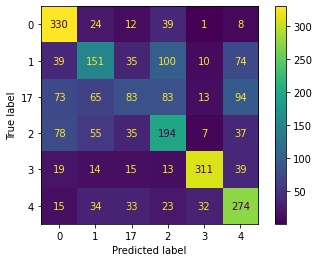

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 46/59
----------

train Loss: 1.1803 Acc: 0.5463
train Epoch Entropy: 1.7232
train Balanced Accuracy: 0.3333



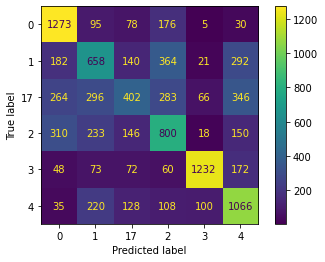

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7468 Acc: 0.6124
val Epoch Entropy: 1.9091
val Balanced Accuracy: 0.7000



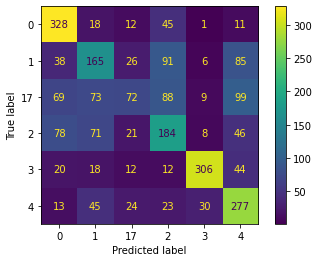

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 47/59
----------

train Loss: 1.1785 Acc: 0.5436
train Epoch Entropy: 1.7207
train Balanced Accuracy: 0.2500



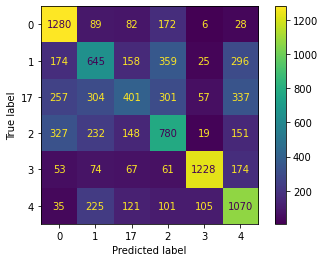

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7656 Acc: 0.6280
val Epoch Entropy: 1.9229
val Balanced Accuracy: 0.5833



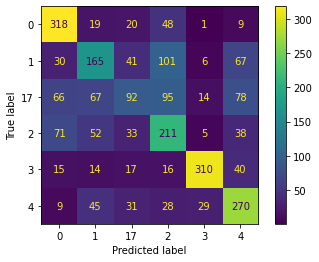

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 48/59
----------

train Loss: 1.1750 Acc: 0.5428
train Epoch Entropy: 1.7244
train Balanced Accuracy: 0.7500



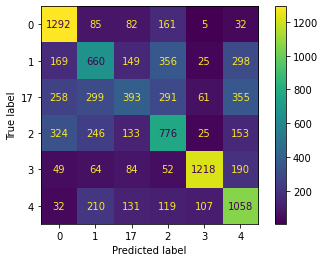

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7563 Acc: 0.6170
val Epoch Entropy: 1.9191
val Balanced Accuracy: 0.6250



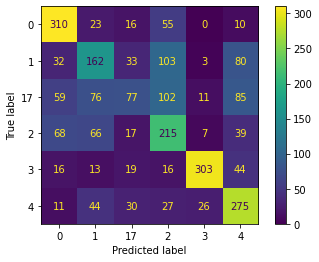

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 49/59
----------

train Loss: 1.1799 Acc: 0.5481
train Epoch Entropy: 1.7233
train Balanced Accuracy: 0.2500



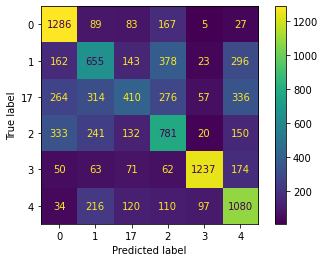

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7580 Acc: 0.6156
val Epoch Entropy: 1.9292
val Balanced Accuracy: 0.3333



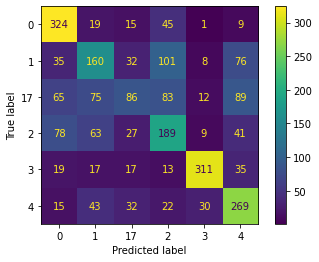

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 50/59
----------

train Loss: 1.1778 Acc: 0.5428
train Epoch Entropy: 1.7205
train Balanced Accuracy: 0.6250



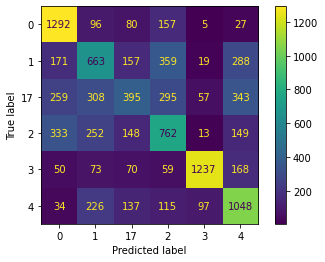

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7471 Acc: 0.6143
val Epoch Entropy: 1.9227
val Balanced Accuracy: 0.6667



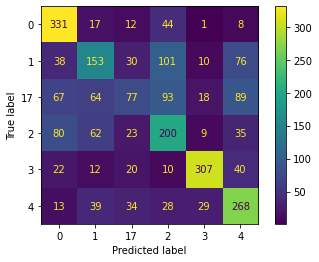

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 51/59
----------

train Loss: 1.1829 Acc: 0.5402
train Epoch Entropy: 1.7242
train Balanced Accuracy: 0.3333



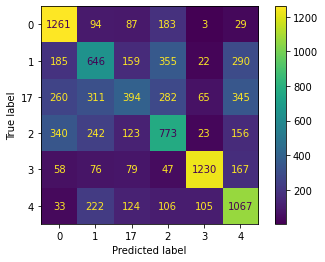

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7461 Acc: 0.6152
val Epoch Entropy: 1.9105
val Balanced Accuracy: 0.6250



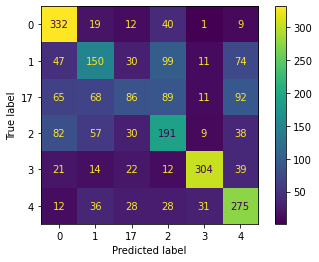

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 52/59
----------

train Loss: 1.1825 Acc: 0.5443
train Epoch Entropy: 1.7233
train Balanced Accuracy: 0.6667



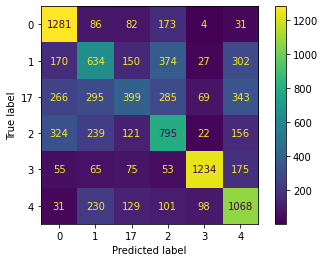

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7561 Acc: 0.6202
val Epoch Entropy: 1.9209
val Balanced Accuracy: 1.0000



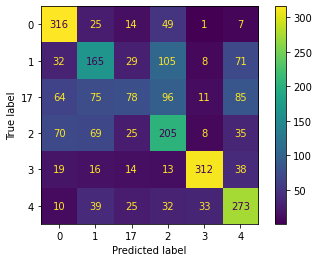

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 53/59
----------

train Loss: 1.1809 Acc: 0.5418
train Epoch Entropy: 1.7187
train Balanced Accuracy: 0.3333



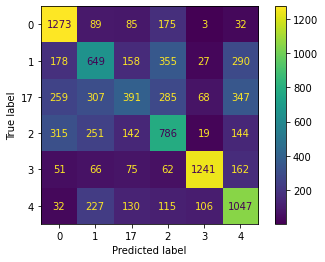

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7571 Acc: 0.6170
val Epoch Entropy: 1.9182
val Balanced Accuracy: 0.6250



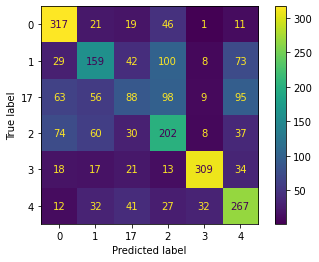

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 54/59
----------

train Loss: 1.1792 Acc: 0.5416
train Epoch Entropy: 1.7226
train Balanced Accuracy: 0.7000



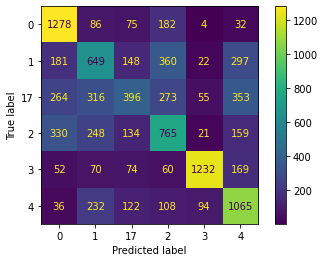

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7540 Acc: 0.6161
val Epoch Entropy: 1.9193
val Balanced Accuracy: 0.6111



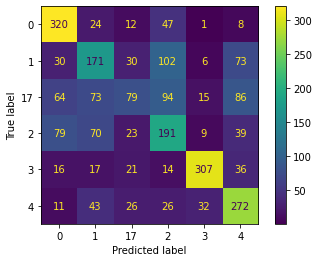

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 55/59
----------

train Loss: 1.1765 Acc: 0.5464
train Epoch Entropy: 1.7222
train Balanced Accuracy: 1.0000



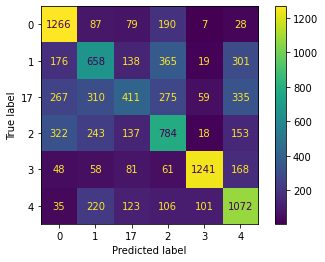

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7576 Acc: 0.6225
val Epoch Entropy: 1.9346
val Balanced Accuracy: 0.3000



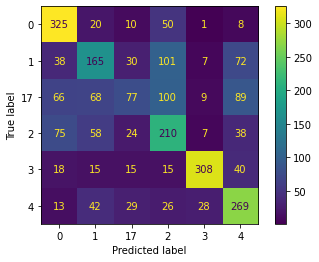

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 56/59
----------

train Loss: 1.1750 Acc: 0.5456
train Epoch Entropy: 1.7248
train Balanced Accuracy: 0.5556



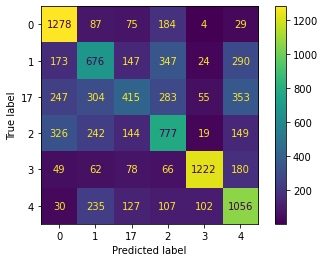

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7566 Acc: 0.6207
val Epoch Entropy: 1.9227
val Balanced Accuracy: 0.8889



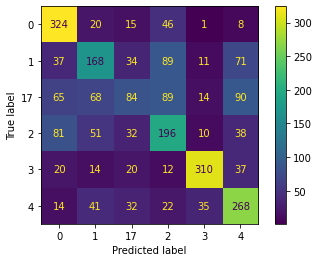

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 57/59
----------

train Loss: 1.1746 Acc: 0.5471
train Epoch Entropy: 1.7218
train Balanced Accuracy: 0.6250



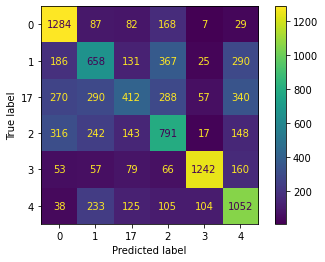

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7505 Acc: 0.6202
val Epoch Entropy: 1.9133
val Balanced Accuracy: 0.3750



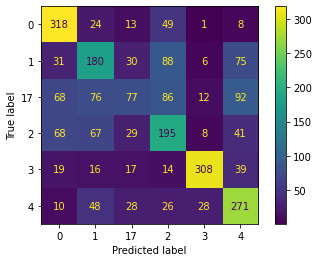

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 58/59
----------

train Loss: 1.1780 Acc: 0.5430
train Epoch Entropy: 1.7197
train Balanced Accuracy: 0.7222



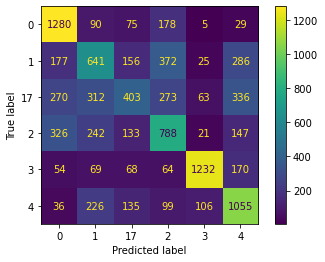

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7487 Acc: 0.6189
val Epoch Entropy: 1.9137
val Balanced Accuracy: 0.3750



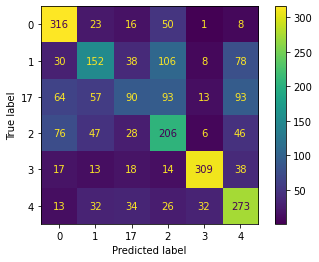

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Epoch 59/59
----------

train Loss: 1.1816 Acc: 0.5471
train Epoch Entropy: 1.7221
train Balanced Accuracy: 0.5000



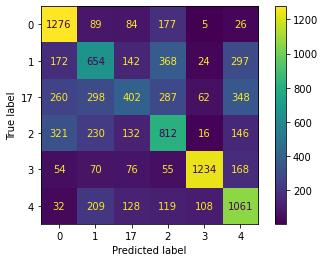

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7592 Acc: 0.6147
val Epoch Entropy: 1.9262
val Balanced Accuracy: 0.9000



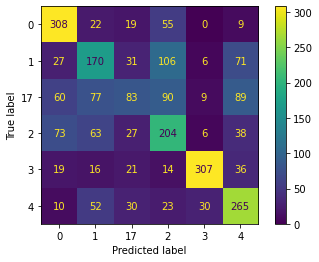

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

Training complete in 105m 5s
Best val Acc: 0.628046
Best Val Acc. was achieved at epoch 47


In [41]:
model_list = []
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)


    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val,E_accuracy_train,E_accuracy_val = train_model(trainset,valset,model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    


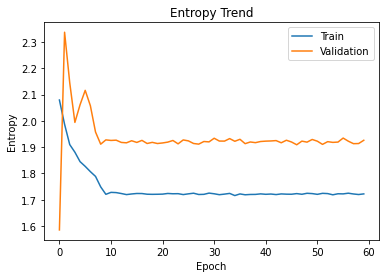

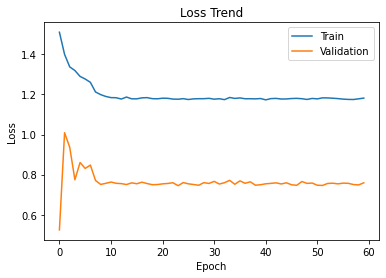

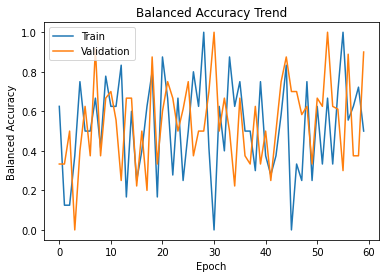

In [61]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Trend')
plt.legend()
plt.show()




In [43]:

# Assuming you have a trained model named "model"


# Define the file path to save the model
model_file1 = './model_state.pt'

# Save the model
torch.save(model.state_dict(), model_file1)

model_file2 = './model_entire.pt'

# Save the entire model
torch.save(model, model_file2)


In [40]:

# Create an instance of the ResNet50 model
model = torch.load('./model_entire.pt')

# Load the state dictionary from the model_state file
state_dict = torch.load('./model_state.pt')

# Load the state dictionary into the model
model.load_state_dict(state_dict)



<All keys matched successfully>

The Test Accuracy: tensor(0.6243, device='cuda:0')
The Test Balanced Accuracy: 0.5460713127230082
Skipped Inputs: 275


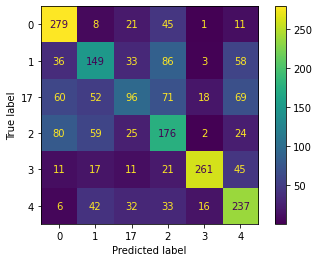

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6196, device='cuda:0')
The Test Balanced Accuracy: 0.5419804376575094
Skipped Inputs: 275


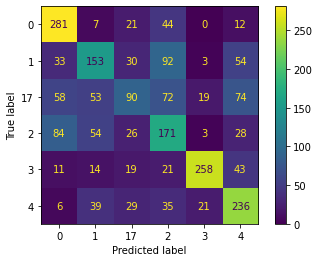

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6285, device='cuda:0')
The Test Balanced Accuracy: 0.5497292711530304
Skipped Inputs: 275


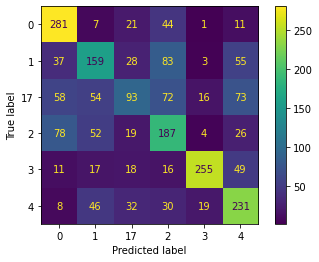

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6347, device='cuda:0')
The Test Balanced Accuracy: 0.5551949996257205
Skipped Inputs: 275


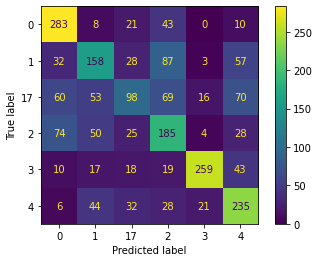

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6258, device='cuda:0')
The Test Balanced Accuracy: 0.5474449185318262
Skipped Inputs: 275


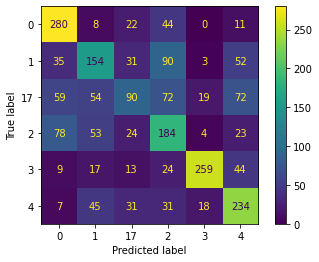

<Figure size 576x432 with 0 Axes>

In [42]:
for hardness_threshold in [30,35,40,60,75]:
    test_model(model, testset, hardness_threshold)


In [ ]:
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)


In [54]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.14949863263445762


Accuracy for SVM: 0.5546946216955333
Balanced Accuracy:0.5547533498016318


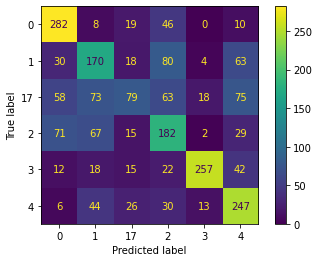

<Figure size 576x432 with 0 Axes>

In [55]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.5278030993618961
Balanced Accuracy:0.5278513860817926


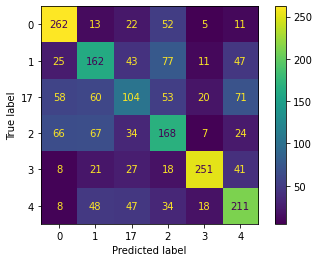

<Figure size 576x432 with 0 Axes>

In [56]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()